In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir, path, makedirs
from itertools import product
from cv2 import imread, VideoWriter, destroyAllWindows, VideoWriter_fourcc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D


In [25]:
# https://github.com/amaotone/pygtm/blob/master/examples/iris.ipynb
class GTM(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, n_rbfs=10, sigma=1, alpha=1e-3, n_grids=20, 
                 method='mean', max_iter=10, tol=1e-3, random_state=None, verbose=False):
        self.n_components = n_components
        self.n_rbfs = n_rbfs
        self.sigma = sigma
        self.alpha = alpha
        self.n_grids = n_grids
        self.max_iter = max_iter
        self.method = method
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.prev_likelihood_ = -float('inf')
    
    def get_lattice_points(self, n_grid):
        grid = np.meshgrid(*[np.linspace(-1, 1, n_grid + 1) for _ in range(self.n_components)])
        return np.array([c.ravel() for c in grid]).T
    
    def init(self, X):
        # generate map
        # (grid*grid,n_components) matrix numbers between -1 and 1
        self.z = self.get_lattice_points(self.n_grids)
        # (rbfs*rbfs,n_components)  matrix numbers between -1 and 1
        self.rbfs = self.get_lattice_points(self.n_rbfs)
        # (grid*grid,rbfs*rbfs) matrix with the square euclidean distance of each point between this 2 matrices.
        d = cdist(self.z, self.rbfs, 'sqeuclidean')
        # (grid*grid,rbfs*rbfs) matrix with number e exponential to -d matrix divided by 2times sigma
        self.phi = np.exp(-d / (2 * self.sigma))
        
        # init W and beta from PCA
        pca = PCA(n_components=self.n_components + 1, random_state=self.random_state)
        pca.fit(X)
        # (grid*grid,rbfs*rbfs) * (grid*grid,n_components) * (n_components,n_original_columns) = (rbfs*rbfs,n_original_columns) 
        self.W = np.linalg.pinv(self.phi).dot(self.z).dot(pca.components_[:self.n_components, :])
        
        # the explained_variance_ of the last component
        betainv1 = pca.explained_variance_[self.n_components]
        # (grid*grid,rbfs*rbfs) * (rbfs*rbfs,n_original_columns)  = (grid*grid,n_original_columns) 
        # (grid*grid,grid*grid) matrix with the square euclidean distance of each point between this 2 matrices.
        inter_dist = cdist(self.phi.dot(self.W), self.phi.dot(self.W))
        np.fill_diagonal(inter_dist, np.inf)
        betainv2 = inter_dist.min(axis=0).mean() / 2
        self.beta = 1 / max(betainv1, betainv2)
    
    def responsibility(self, X):
        p = np.exp((-self.beta / 2) * cdist(self.phi.dot(self.W), X, 'sqeuclidean'))
        return p / p.sum(axis=0)
    
    def likelihood(self, X):
        R = self.responsibility(X)
        D = X.shape[1]
        k1 = (D / 2) * np.log(self.beta / (2 * np.pi))
        k2 = -(self.beta / 2) * cdist(self.phi.dot(self.W), X, 'sqeuclidean')
        return (R * (k1 + k2)).sum()
    
    def fit(self, X, y=None, **fit_params):
        self.init(X)
        
        for i in range(self.max_iter):
            R = self.responsibility(X)
            G = np.diag(R.sum(axis=1))
            self.W = np.linalg.solve(
                self.phi.T.dot(G).dot(self.phi) + (self.alpha / self.beta) * np.identity(self.phi.shape[1]),
                self.phi.T.dot(R).dot(X))
            
            self.beta = X.size / (cdist(self.phi.dot(self.W), X, 'sqeuclidean') * R).sum()
            print("beta")
            print(self.)
            
            likelihood = self.likelihood(X)
            diff = abs(likelihood - self.prev_likelihood_) / X.shape[0]
            self.prev_likelihood_ = likelihood
            if self.verbose:
                print('cycle #{}: likelihood: {:.3f}, diff: {:.3f}'.format(i + 1, likelihood, diff))
            
            if diff < self.tol:
                if self.verbose:
                    print('converged.')
                break
        return self
    
    def transform(self, X, y=None):
        assert self.method in ('mean', 'mode')
        if self.method == 'mean':
            R = self.responsibility(X)
            return self.z.T.dot(R).T
        elif self.method == 'mode':
            return self.z[self.responsibility(X).argmax(axis=0), :]
    
    def inverse_transform(self, Xt):
        d = cdist(Xt, self.rbfs, 'sqeuclidean')
        phi = np.exp(-d / (2 * self.sigma))
        return phi.dot(self.W)

In [3]:
def make_video(video_name,folder='./'):

    images = [img for img in listdir(folder) if img.endswith(".png")]
    frame = imread(path.join(folder, images[0]))
    height, width, layers = frame.shape

    video = VideoWriter(folder+video_name, -1, 1, (width,height))

    for image in images[:-1]:
        video.write(imread(path.join(folder, image)))

    destroyAllWindows()
    video.release()

In [4]:
#https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
#http://tsaith.github.io/combine-images-into-a-video-with-python-3-and-opencv-3.html
#http://tsaith.github.io/combine-images-into-a-video-with-python-3-and-opencv-3.html
#https://opencv.org/opencv-3-0.html
def make_video2(video_name,folder='./'):

    #image_folder = 'imgs'

    images = [img for img in listdir(folder) if img.endswith(".png")]
    frame = imread(path.join(folder, images[0]))
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    video = VideoWriter(folder+'/'+video_name, fourcc, 1.0, (width, height))

    for image in images[:-1]:
        video.write(imread(path.join(folder, image)))

    destroyAllWindows()
    video.release()

In [5]:
def getVariances(data,targets,mean):
    Sw = 0
    Sb = 0
    class_means = pd.DataFrame()
    pd_iris_target = pd.DataFrame(targets)
    for current_class in np.unique(targets):
        current_class_data = data.iloc[pd_iris_target[pd_iris_target[0]==current_class].index]
        current_class_mean = np.mean(current_class_data)
        class_means=class_means.append(current_class_mean,ignore_index=True)
        x_i = current_class_data - current_class_mean
        diff_mean = pd.DataFrame(current_class_mean - mean)
        Sw += x_i.T.dot(x_i)
        Sb += diff_mean.dot(diff_mean.T) 
    return Sw, Sb, class_means


def GT(data,targets,n_grids=15,gtm_flag=False,folder='./'):
    if gtm_flag:
        model = make_pipeline(
            StandardScaler(),
            GTM(n_components=3, max_iter=50, tol=1e-2, verbose=True)
        )
        model.fit(data)
        GTM_structure = model.transform(data)
        
    else:
        initial_point = -1
        final_point = 1
        grid_lenght = (final_point-initial_point)/(n_grids-1)
        GTM_structure = np.array(list(product(np.arange(initial_point, (final_point+grid_lenght), grid_lenght), repeat=2)))
        
    GTM_structure_orthonormal, R = np.linalg.qr(GTM_structure)
    GTM_structure_orthonormal2 = GTM_structure_orthonormal * GTM_structure_orthonormal
    
    GTM_structures=[]
    for point in range(len(GTM_structure_orthonormal2)):
        GTM_structures.append(pd.DataFrame(data-data*GTM_structure_orthonormal2[point,0]-data*GTM_structure_orthonormal2[point,1])) 
    
    if not path.exists(folder):
        makedirs(folder)
    i=1

    GTM_transformed=[]

    for current_manifold in GTM_structures:
        overall_mean = np.mean(current_manifold,0)
        current_data = current_manifold  - overall_mean
    #overall_mean = np.mean(iris.structure[100],0)
    #current_data = iris.structure[100]  - overall_mean
        n_dimensions = len(current_data.columns)

        Sw, Sb, class_means = getVariances(current_data,targets,overall_mean)

        M = np.linalg.pinv(Sw).dot(Sb)
        J = np.trace(M)

        print('Original data')
        print('Cluster performance indices: tr(Sb)= '+str(np.trace(Sb))+' tr(Sw)= '+str(np.trace(Sw))+' tr(Sb)/tr(Sw)= '+str(np.trace(Sb)/np.trace(Sw)))
        print('Invariant criterion:         tr(inv(Sw)*Sb)= '+str(J))

        vectors_Sw, diag_Sw = eigh(Sw)
        values_M, vectors_M = eigh(M)
        sorted_values_M = np.sort(values_M)

        main_vectors = vectors_M[:,np.argsort(values_M)[n_dimensions-3:n_dimensions]]

        explaination = 100*sum(sorted_values_M[n_dimensions-3:n_dimensions])/sum(sorted_values_M) # explaination of 3 first eiginvalues
        
        print('Explaination '+str(explaination))

        transformed_means = class_means.dot(main_vectors)
        transformed_data = current_data.dot(main_vectors)

        GTM_transformed.append(transformed_data)

        name="GTM_point"+'{0:03d}'.format(i)

        fig = plt.figure(name)
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(xs=transformed_data[0],ys=transformed_data[1],zs=transformed_data[2],c=targets, cmap=plt.cm.rainbow)
        plt.gca().set_title(name)
        plt.gca().set_xlabel("Component1")
        plt.gca().set_ylabel("Component2")
        plt.gca().set_zlabel("Component3")
        plt.savefig(folder+"/"+name+".png")
        plt.show()

        T_Sw, T_Sb, t_class_means = getVariances(transformed_data,targets,np.mean(transformed_data,0))
        T_M = np.linalg.pinv(T_Sw).dot(T_Sb)
        T_J = np.trace(T_M)

        print('Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain')
        print('Cluster performance indices: tr(Sb)= '+str(np.trace(T_Sb))+' tr(Sw)= '+str(np.trace(T_Sw))+' tr(Sb)/tr(Sw)= '+str(np.trace(T_Sb)/np.trace(T_Sw)))
        print('Invariant criterion:         tr(inv(Sw)*Sb)= '+str(T_J))

        i+=1
        
        make_video2('GrandTour.avi',folder)


In [13]:
iris = load_iris()
sonar=pd.read_csv('data/sonar/sonar.all-data.csv',header=None)
urban=pd.read_csv('data/ULC/data3.csv',header=None)
olive=pd.read_csv('data/olive/olivedata.csv',header=None)

In [14]:
sonar_labels=(pd.get_dummies(sonar[60])*list(range(1,len(list(pd.get_dummies(sonar[60])))+1))).astype(int).sum(axis=1)-1
urban_labels=(pd.get_dummies(urban[0])*list(range(1,len(list(pd.get_dummies(urban[0])))+1))).astype(int).sum(axis=1)-1
olive_labels=(pd.get_dummies(olive[0])*list(range(1,len(list(pd.get_dummies(olive[0])))+1))).astype(int).sum(axis=1)-1

cycle #1: likelihood: -1.105, diff: inf
cycle #2: likelihood: 125.802, diff: 0.846
cycle #3: likelihood: 217.297, diff: 0.610
cycle #4: likelihood: 293.080, diff: 0.505
cycle #5: likelihood: 358.411, diff: 0.436
cycle #6: likelihood: 416.122, diff: 0.385
cycle #7: likelihood: 470.072, diff: 0.360
cycle #8: likelihood: 523.011, diff: 0.353
cycle #9: likelihood: 574.603, diff: 0.344
cycle #10: likelihood: 624.846, diff: 0.335
cycle #11: likelihood: 674.827, diff: 0.333
cycle #12: likelihood: 726.080, diff: 0.342
cycle #13: likelihood: 780.835, diff: 0.365
cycle #14: likelihood: 840.566, diff: 0.398
cycle #15: likelihood: 905.064, diff: 0.430
cycle #16: likelihood: 972.990, diff: 0.453
cycle #17: likelihood: 1041.429, diff: 0.456
cycle #18: likelihood: 1106.045, diff: 0.431
cycle #19: likelihood: 1167.605, diff: 0.410
cycle #20: likelihood: 1221.385, diff: 0.359
cycle #21: likelihood: 1263.580, diff: 0.281
cycle #22: likelihood: 1296.609, diff: 0.220
cycle #23: likelihood: 1319.905, diff:

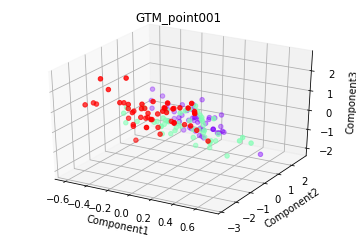

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.385749657813207 tr(Sw)= 75.11582495469793 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.09594594119986 tr(Sw)= 87.09681853694777 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528944


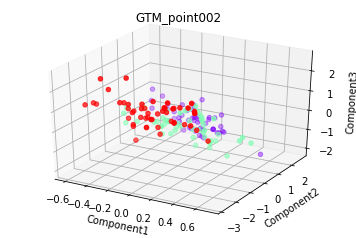

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.38421284674747 tr(Sw)= 75.10470983688693 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 185.12925989649983 tr(Sw)= 87.5856851309204 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.5348534252893


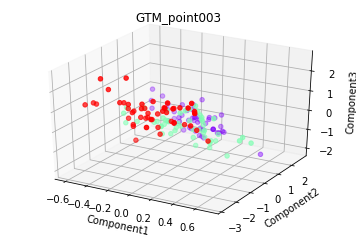

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.442498497713299 tr(Sw)= 75.52626580536004 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 184.49737717638314 tr(Sw)= 87.28673789267852 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017133
Explaination 112.53485342528906


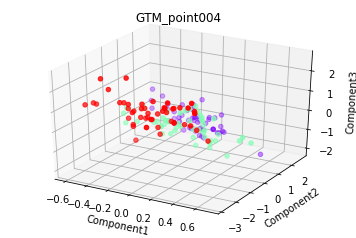

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.406856188338542 tr(Sw)= 75.26847974655969 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 181.8980424581969 tr(Sw)= 86.05697814371071 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528913


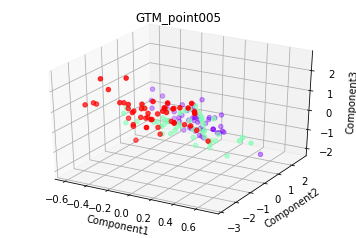

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.260236745766978 tr(Sw)= 74.20804205587491 tr(Sb)/tr(Sw)= 0.13826313781519176
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037924
Original data
Cluster performance indices: tr(Sb)= 181.2892223053654 tr(Sw)= 85.7689419346477 tr(Sb)/tr(Sw)= 2.1136931179995213
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171217
Explaination 112.5348534252897


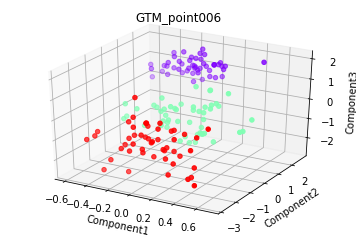

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.225895315704127 tr(Sw)= 73.95966471824539 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 184.29035440637242 tr(Sw)= 87.18879426583497 tr(Sb)/tr(Sw)= 2.113693117999532
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171417
Explaination 112.53485342528974


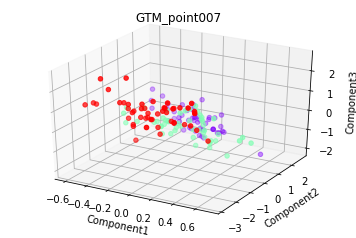

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.395178752983103 tr(Sw)= 75.18402169403782 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 184.76425649738098 tr(Sw)= 87.4129999875517 tr(Sb)/tr(Sw)= 2.1136931179995293
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017136
Explaination 112.53485342528968


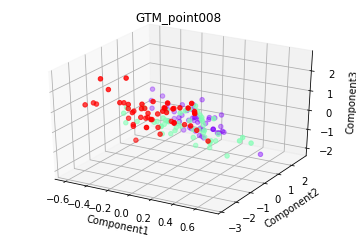

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.421909923821204 tr(Sw)= 75.37735717926185 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 179.22163073817103 tr(Sw)= 84.7907528353939 tr(Sb)/tr(Sw)= 2.1136931179995275
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342528941


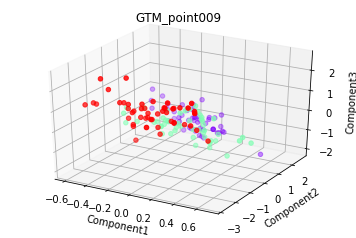

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.109269657251286 tr(Sw)= 73.11615964309857 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 185.72052844948809 tr(Sw)= 87.8654175802308 tr(Sb)/tr(Sw)= 2.113693117999522
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528938


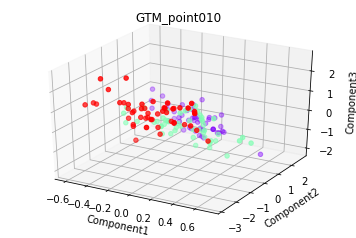

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.47584990299508 tr(Sw)= 75.76748270386824 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 182.10007058795512 tr(Sw)= 86.15255877840062 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342528948


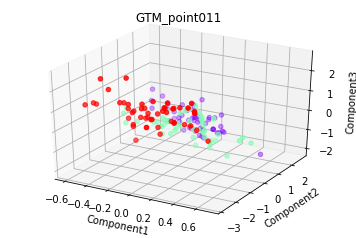

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.271632450814725 tr(Sw)= 74.2904624697888 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 184.4012257205251 tr(Sw)= 87.24124810277516 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528958


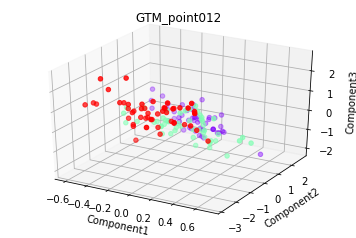

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.401432618699058 tr(Sw)= 75.22925331408334 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 183.51795783055383 tr(Sw)= 86.82336913896074 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528951


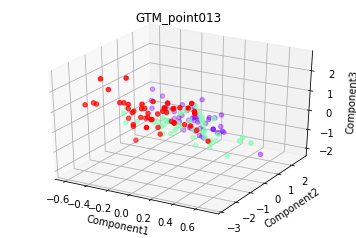

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.35161054508812 tr(Sw)= 74.86891089456194 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 178.09324847768755 tr(Sw)= 84.25690889614167 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528917


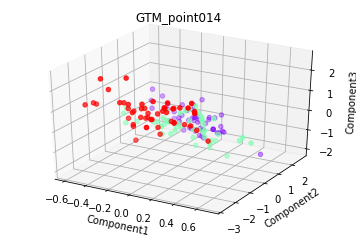

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045621533413236 tr(Sw)= 72.65581912975705 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 180.8746235757348 tr(Sw)= 85.57279296387226 tr(Sb)/tr(Sw)= 2.113693117999523
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017122
Explaination 112.53485342528938


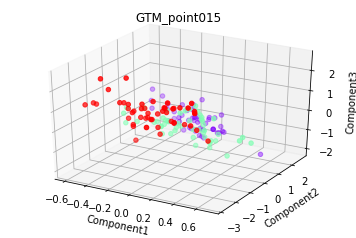

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.202509241489068 tr(Sw)= 73.79052293118193 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 179.39597201357992 tr(Sw)= 84.87323466491036 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528944


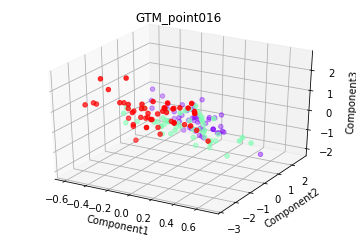

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.119103643016505 tr(Sw)= 73.18728478838753 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 181.28923993170892 tr(Sw)= 85.768950273769 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017124
Explaination 112.53485342528941


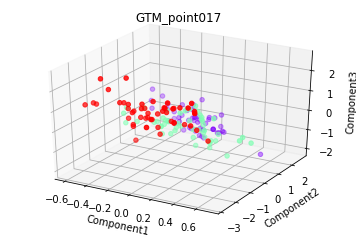

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.225896309944929 tr(Sw)= 73.95967190917729 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 184.0402850493951 tr(Sw)= 87.07048505867175 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.53485342528987


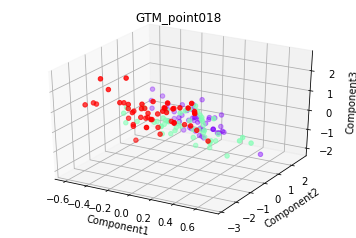

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.381073209180823 tr(Sw)= 75.0820021389693 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 180.87462389981354 tr(Sw)= 85.57279311719593 tr(Sb)/tr(Sw)= 2.1136931179995178
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017114
Explaination 112.53485342528948


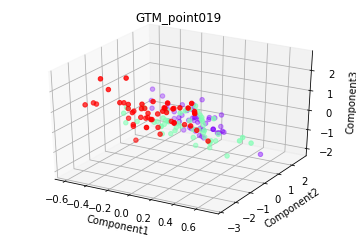

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.202509259769243 tr(Sw)= 73.79052306339486 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 183.03496062909178 tr(Sw)= 86.5948604697748 tr(Sb)/tr(Sw)= 2.1136931179995213
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528916


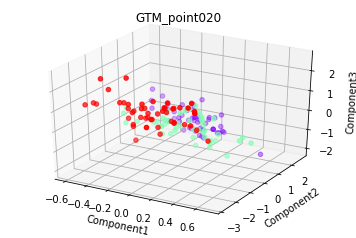

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.3243663506616 tr(Sw)= 74.67186492224401 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 184.92377304379687 tr(Sw)= 87.48846815511972 tr(Sb)/tr(Sw)= 2.1136931179995218
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.53485342528961


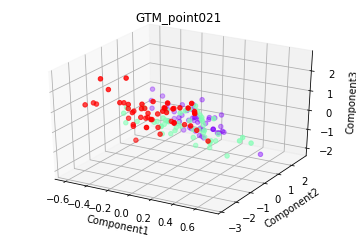

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.430907698118183 tr(Sw)= 75.44243435340353 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 183.22170429676345 tr(Sw)= 86.6832099402259 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528946


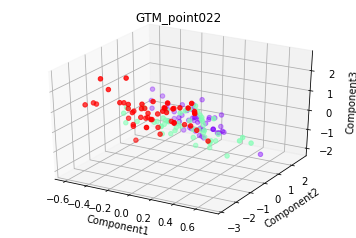

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.334899912294164 tr(Sw)= 74.7480498099807 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 183.2965227039419 tr(Sw)= 86.71860694584667 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342528973


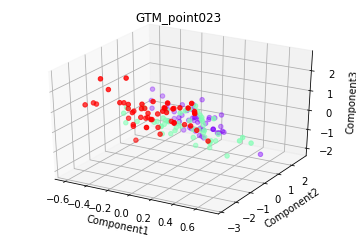

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.339120158758696 tr(Sw)= 74.77857310441199 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 187.1424080742447 tr(Sw)= 88.53811675905114 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528934


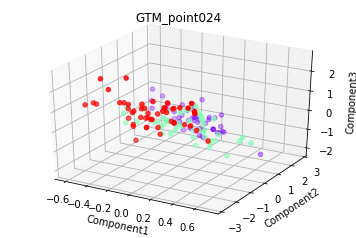

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.556053193678297 tr(Sw)= 76.34755988098554 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 184.29062927132142 tr(Sw)= 87.18892430597523 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.53485342528965


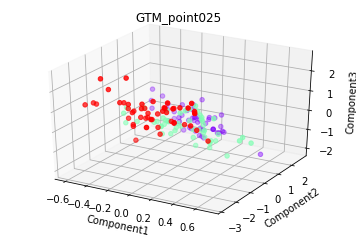

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.395194257160163 tr(Sw)= 75.1841338293278 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 186.64464544257382 tr(Sw)= 88.30262248250133 tr(Sb)/tr(Sw)= 2.113693117999532
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601714
Explaination 112.53485342528941


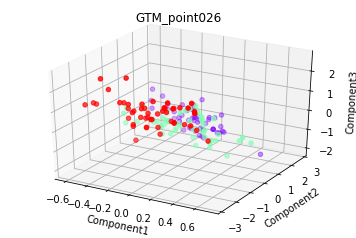

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.527976132621863 tr(Sw)= 76.14449012935029 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 185.4732874807403 tr(Sw)= 87.74844649930971 tr(Sb)/tr(Sw)= 2.1136931179995235
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017125
Explaination 112.53485342528964


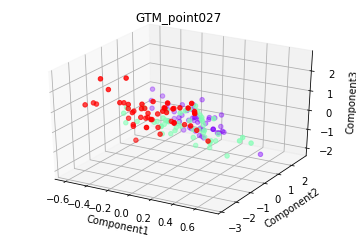

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.461903898748265 tr(Sw)= 75.66661703231483 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 184.28467238279435 tr(Sw)= 87.18610606879771 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528992


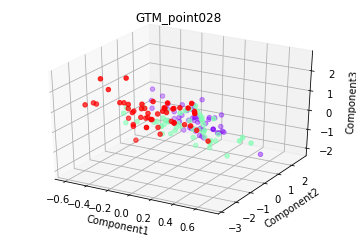

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.394858249769804 tr(Sw)= 75.18170362706519 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.85770957129196 tr(Sw)= 87.45721315791003 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528919


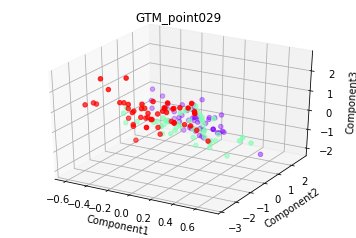

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.427181287108004 tr(Sw)= 75.41548276624108 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 183.30050396804316 tr(Sw)= 86.72049050409233 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342528941


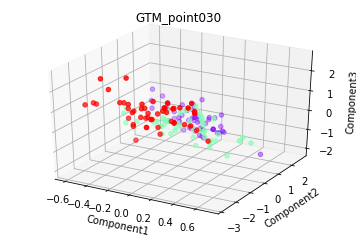

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.33934472803759 tr(Sw)= 74.78019732097792 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 185.68271616447876 tr(Sw)= 87.84752837735279 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528936


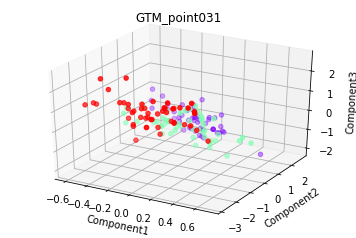

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.47371704333999 tr(Sw)= 75.75205661352493 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 186.6994845197129 tr(Sw)= 88.32856715567681 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.53485342528944


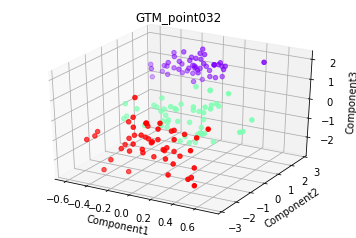

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.531069414477827 tr(Sw)= 76.16686255561548 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037926
Original data
Cluster performance indices: tr(Sb)= 181.48140811924367 tr(Sw)= 85.85986611481432 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171297
Explaination 112.53485342528938


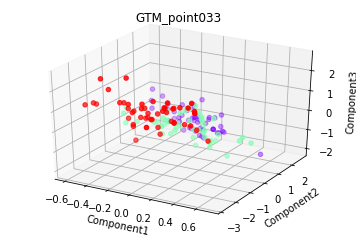

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.236735849900754 tr(Sw)= 74.03806981137379 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 180.87462264488124 tr(Sw)= 85.57279252348026 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017122
Explaination 112.53485342528985


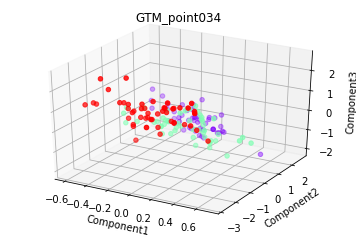

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.20250918898282 tr(Sw)= 73.79052255142601 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037922
Original data
Cluster performance indices: tr(Sb)= 185.72052844948809 tr(Sw)= 87.8654175802308 tr(Sb)/tr(Sw)= 2.113693117999522
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528938


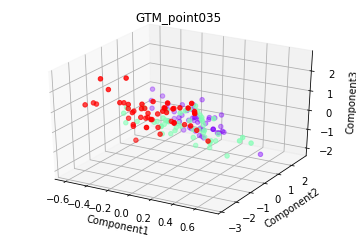

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.47584990299508 tr(Sw)= 75.76748270386824 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 185.7190166170983 tr(Sw)= 87.86470232389713 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.5348534252896


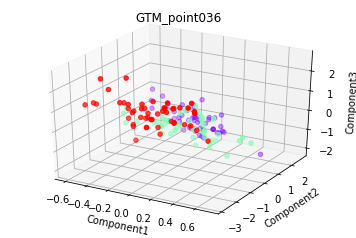

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.475764625781345 tr(Sw)= 75.76686592910761 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 184.28487429046402 tr(Sw)= 87.1862015924422 tr(Sb)/tr(Sw)= 2.1136931179995218
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017122
Explaination 112.53485342528917


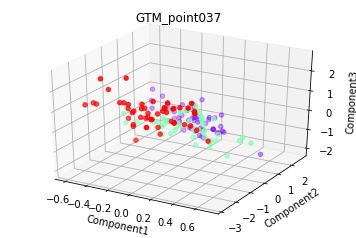

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.394869638680168 tr(Sw)= 75.18178599833598 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 185.72052844948809 tr(Sw)= 87.8654175802308 tr(Sb)/tr(Sw)= 2.113693117999522
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528938


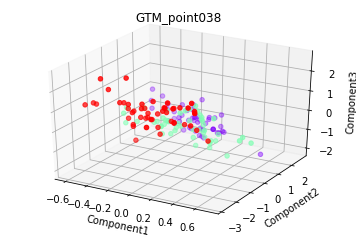

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.47584990299508 tr(Sw)= 75.76748270386824 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 181.17387885401286 tr(Sw)= 85.71437230466188 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528977


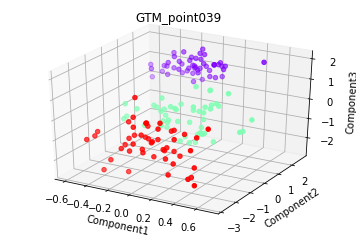

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.219389192262865 tr(Sw)= 73.91260862257113 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.85822709183353 tr(Sw)= 87.45745799976407 tr(Sb)/tr(Sw)= 2.1136931179995218
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171213
Explaination 112.53485342528947


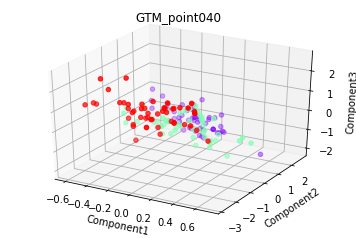

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.427210478644126 tr(Sw)= 75.41569389652926 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 184.92434626034049 tr(Sw)= 87.48873934706259 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528968


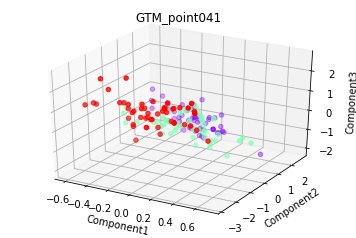

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.430940031272286 tr(Sw)= 75.44266820571318 tr(Sb)/tr(Sw)= 0.13826313781519148
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 178.09322219693757 tr(Sw)= 84.25689646257229 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528954


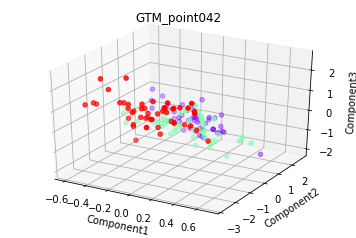

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045620051007395 tr(Sw)= 72.6558084081297 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 184.01963753100628 tr(Sw)= 87.06071660259214 tr(Sb)/tr(Sw)= 2.1136931179995284
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171346
Explaination 112.5348534252895


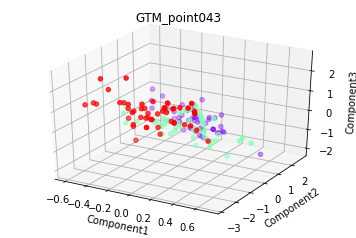

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.379908554388395 tr(Sw)= 75.07357867331659 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 185.46183927590775 tr(Sw)= 87.74303028976885 tr(Sb)/tr(Sw)= 2.1136931179995186
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171186
Explaination 112.53485342528955


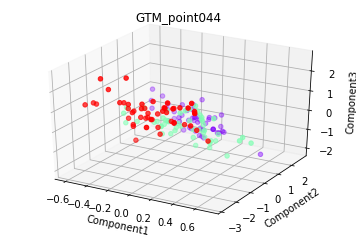

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.461258145279434 tr(Sw)= 75.66194656497962 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 182.42850263781673 tr(Sw)= 86.3079418125152 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528957


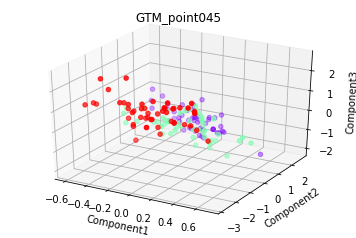

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.290158161927057 tr(Sw)= 74.42445126394661 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037922
Original data
Cluster performance indices: tr(Sb)= 183.52684989927613 tr(Sw)= 86.8275760262551 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.5348534252895


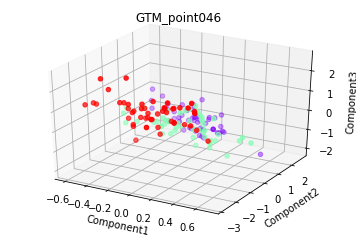

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.352112115797821 tr(Sw)= 74.8725385477284 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 180.87551275226437 tr(Sw)= 85.57321363824646 tr(Sb)/tr(Sw)= 2.1136931179995218
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171217
Explaination 112.53485342528931


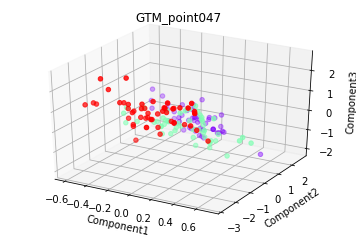

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.202559396848525 tr(Sw)= 73.79088568411989 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 183.93947040738567 tr(Sw)= 87.02278908939846 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528927


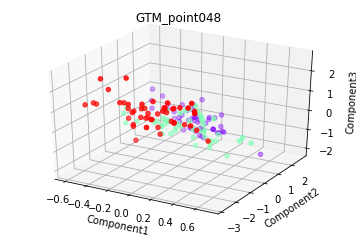

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.375386605408336 tr(Sw)= 75.04087328957138 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 181.29189293980437 tr(Sw)= 85.77020542669204 tr(Sb)/tr(Sw)= 2.1136931179995235
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528967


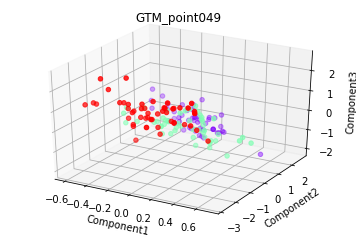

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.226045956916277 tr(Sw)= 73.96075424372935 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037924
Original data
Cluster performance indices: tr(Sb)= 183.75352304445107 tr(Sw)= 86.93481635515838 tr(Sb)/tr(Sw)= 2.113693117999528
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171355
Explaination 112.53485342528947


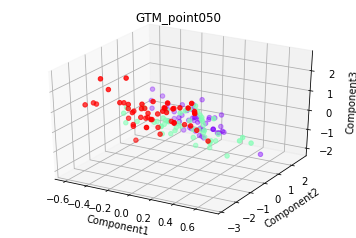

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.364897960559919 tr(Sw)= 74.96501326632763 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 182.8285418244613 tr(Sw)= 86.49720258232024 tr(Sb)/tr(Sw)= 2.113693117999528
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171337
Explaination 112.53485342528944


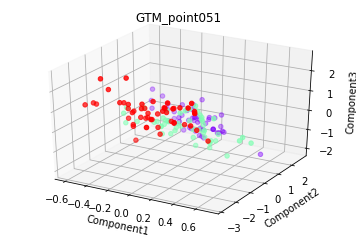

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.312722982895362 tr(Sw)= 74.58765326648228 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037922
Original data
Cluster performance indices: tr(Sb)= 185.29258521009274 tr(Sw)= 87.66295524747703 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528948


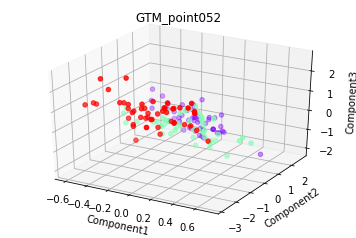

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.451711111336774 tr(Sw)= 75.59289682335272 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037912
Original data
Cluster performance indices: tr(Sb)= 182.32372860244422 tr(Sw)= 86.25837263216404 tr(Sb)/tr(Sw)= 2.113693117999531
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601714
Explaination 112.53485342528947


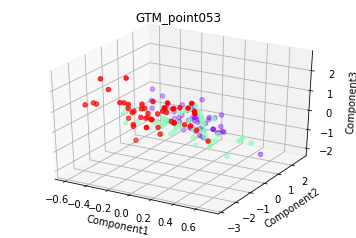

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.284248222527985 tr(Sw)= 74.3817071204789 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 183.2279113443772 tr(Sw)= 86.6861465290622 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017127
Explaination 112.5348534252894


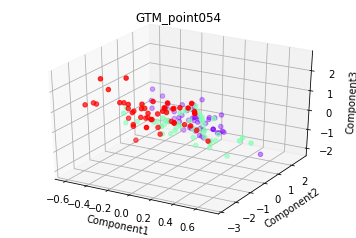

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.33525003028965 tr(Sw)= 74.75058206840484 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703791
Original data
Cluster performance indices: tr(Sb)= 187.4353696031656 tr(Sw)= 88.67671849192624 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528943


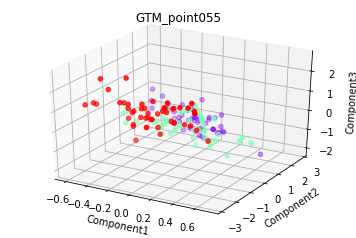

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.572578135912465 tr(Sw)= 76.46707794267067 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 186.65460465329954 tr(Sw)= 88.30733424062814 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528937


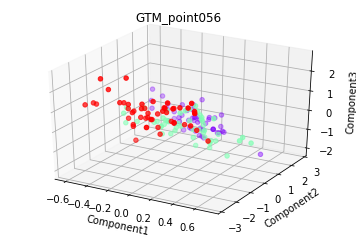

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.528537897105256 tr(Sw)= 76.1485531391465 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 182.91298045966022 tr(Sw)= 86.53715097145958 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017138
Explaination 112.53485342528928


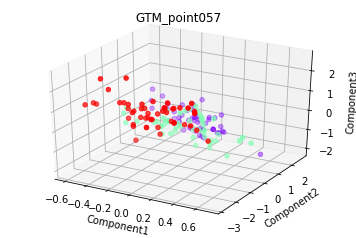

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.317485873006348 tr(Sw)= 74.62210127761702 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 181.77104206913646 tr(Sw)= 85.99689355149678 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.53485342528961


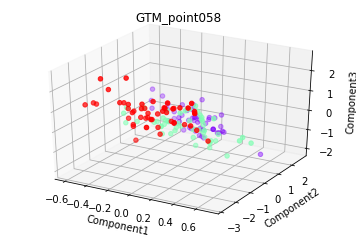

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.253073094960403 tr(Sw)= 74.15623033714957 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 188.15695307617673 tr(Sw)= 89.01810365653046 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017129
Explaination 112.53485342528953


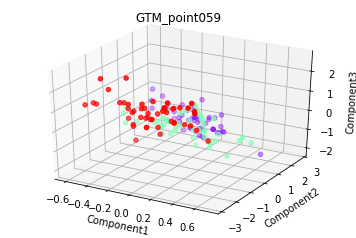

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.613280153179252 tr(Sw)= 76.76145877265864 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 187.42129427683201 tr(Sw)= 88.67005937655439 tr(Sb)/tr(Sw)= 2.113693117999522
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528951


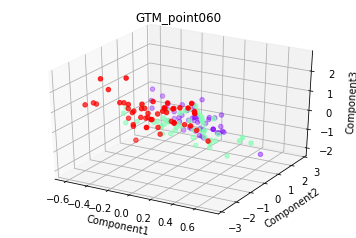

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.571784195645147 tr(Sw)= 76.46133570160865 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 182.2412139179791 tr(Sw)= 86.21933447484506 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528936


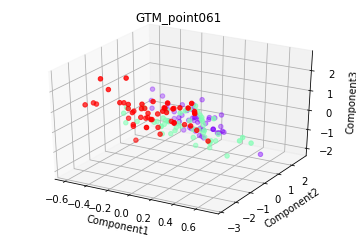

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.279593855795035 tr(Sw)= 74.34804401398141 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 186.12684130749324 tr(Sw)= 88.05764645893838 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.53485342528906


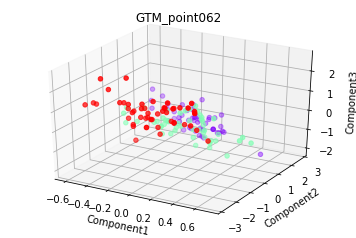

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.498768599973037 tr(Sw)= 75.93324414498778 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 181.4827547991442 tr(Sw)= 85.86050323658422 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171337
Explaination 112.53485342528965


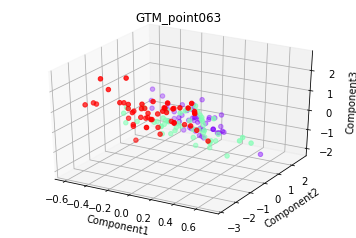

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.236811811436171 tr(Sw)= 74.03861920969224 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 185.97121686572697 tr(Sw)= 87.98401966778259 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528951


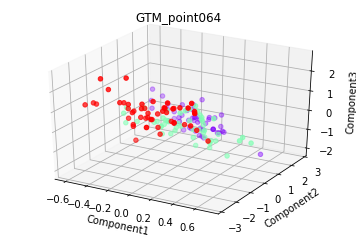

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.489990365779985 tr(Sw)= 75.86975481347282 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 187.88704047124222 tr(Sw)= 88.8904064981132 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528924


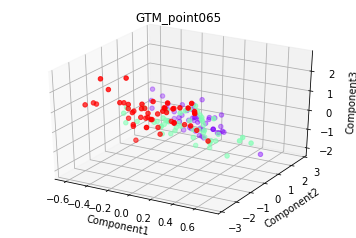

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.598055320685898 tr(Sw)= 76.65134386615546 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 185.27102458986465 tr(Sw)= 87.6527547978259 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017133
Explaination 112.53485342528937


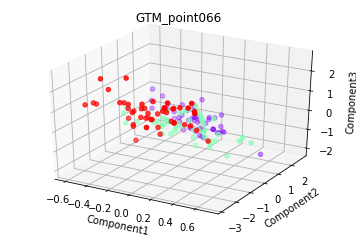

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.450494951641286 tr(Sw)= 75.58410084407217 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 188.70621591019105 tr(Sw)= 89.27796296597175 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528968


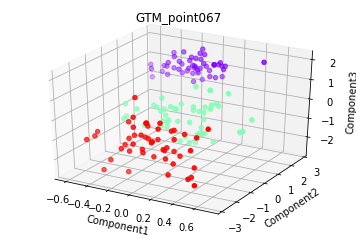

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.644262161762047 tr(Sw)= 76.98553880637101 tr(Sb)/tr(Sw)= 0.13826313781519148
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 184.78377399698533 tr(Sw)= 87.42223382544364 tr(Sb)/tr(Sw)= 2.113693117999523
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017122
Explaination 112.53485342528941


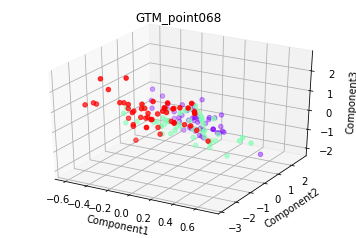

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.423010838179216 tr(Sw)= 75.38531963675703 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 179.39597201357998 tr(Sw)= 84.87323466491036 tr(Sb)/tr(Sw)= 2.113693117999528
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171355
Explaination 112.53485342528941


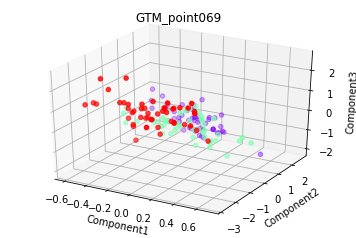

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.119103643016496 tr(Sw)= 73.18728478838752 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 185.001294008753 tr(Sw)= 87.52514375589439 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017127
Explaination 112.5348534252893


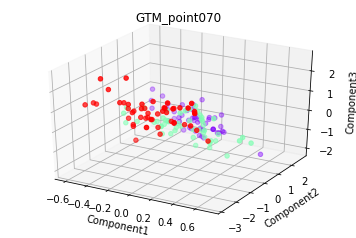

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.435280386479548 tr(Sw)= 75.47406019692522 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 187.23539267997205 tr(Sw)= 88.58210829449969 tr(Sb)/tr(Sw)= 2.113693117999518
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017115
Explaination 112.53485342529002


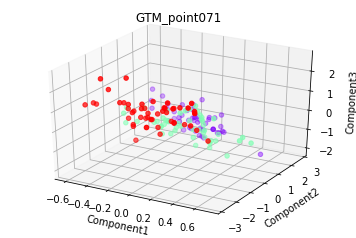

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.561298132302058 tr(Sw)= 76.38549434932352 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 187.48801927111498 tr(Sw)= 88.70162734340553 tr(Sb)/tr(Sw)= 2.1136931179995275
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171315
Explaination 112.53485342528958


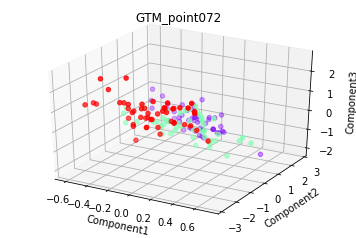

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.575547920800975 tr(Sw)= 76.48855716652915 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 180.18007238442112 tr(Sw)= 85.24419692246995 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171306
Explaination 112.5348534252894


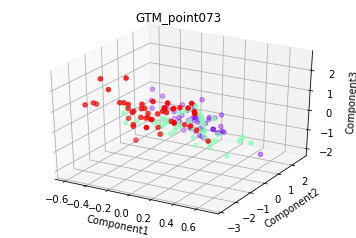

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.163332021335227 tr(Sw)= 73.50717032706117 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 185.97120250701514 tr(Sw)= 87.98401287459593 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171315
Explaination 112.5348534252895


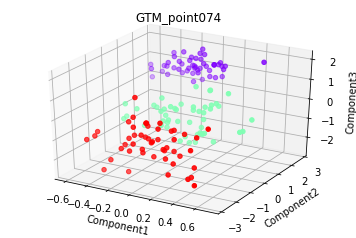

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.489989555854926 tr(Sw)= 75.86974895562037 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 188.34228203799978 tr(Sw)= 89.10578382175689 tr(Sb)/tr(Sw)= 2.113693117999512
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017111
Explaination 112.53485342528943


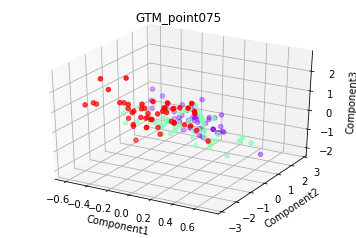

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.623733916169035 tr(Sw)= 76.83706650986875 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 187.47675124271709 tr(Sw)= 88.69629637634054 tr(Sb)/tr(Sw)= 2.1136931179995235
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528933


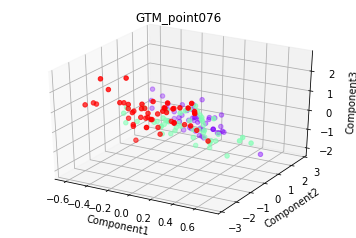

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.574912330458993 tr(Sw)= 76.48396020488023 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 187.27453792578837 tr(Sw)= 88.6006281285677 tr(Sb)/tr(Sw)= 2.1136931179995213
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171204
Explaination 112.53485342528934


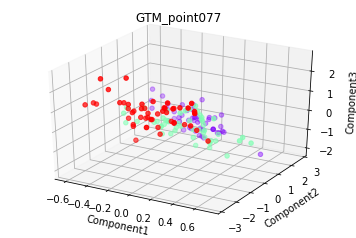

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.563506179646179 tr(Sw)= 76.40146424107493 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 183.87496285841777 tr(Sw)= 86.99227020828992 tr(Sb)/tr(Sw)= 2.113693117999528
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171346
Explaination 112.53485342528934


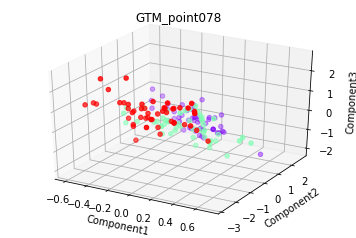

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.371747958640288 tr(Sw)= 75.01455646481575 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037912
Original data
Cluster performance indices: tr(Sb)= 188.70917949542277 tr(Sw)= 89.27936505466995 tr(Sb)/tr(Sw)= 2.1136931179995204
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017124
Explaination 112.53485342528936


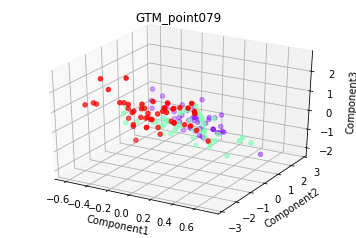

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.644429327310892 tr(Sw)= 76.98674784553704 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037922
Original data
Cluster performance indices: tr(Sb)= 186.34082815101857 tr(Sw)= 88.15888482779289 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528946


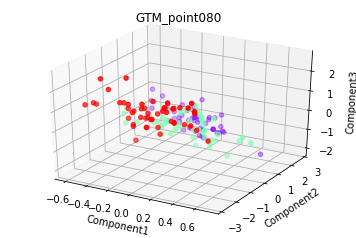

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.5108388545254 tr(Sw)= 76.02054329603477 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 183.41982613677942 tr(Sw)= 86.77694248745739 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.5348534252894


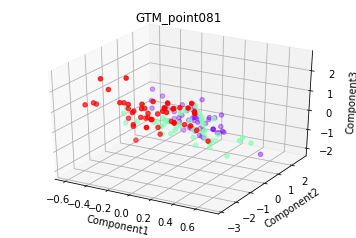

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.34607527710623 tr(Sw)= 74.8288765942462 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 183.02340531830413 tr(Sw)= 86.58939358780911 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017122
Explaination 112.53485342528914


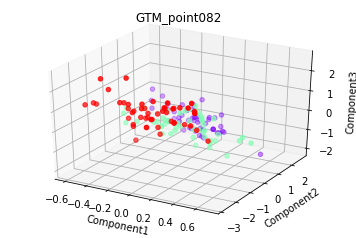

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.323714555717842 tr(Sw)= 74.66715075942334 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 186.11554560807227 tr(Sw)= 88.05230240055785 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528919


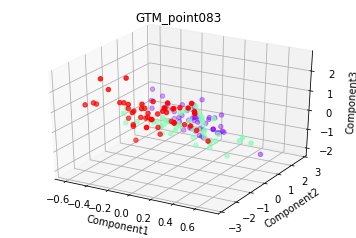

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.498131448804713 tr(Sw)= 75.92863589452858 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.28462579435853 tr(Sw)= 87.18608402754904 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528961


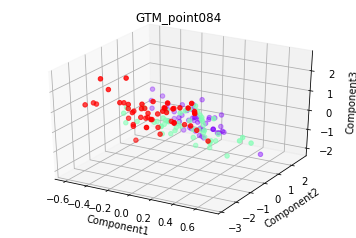

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.394855621878003 tr(Sw)= 75.18168462061232 tr(Sb)/tr(Sw)= 0.13826313781519176
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037924
Original data
Cluster performance indices: tr(Sb)= 188.8396376996383 tr(Sw)= 89.34108555851418 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171324
Explaination 112.53485342528981


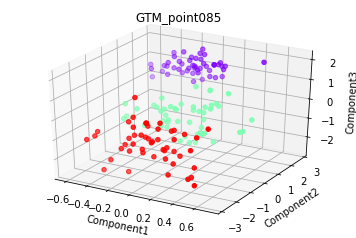

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.651788021459444 tr(Sw)= 77.03997023195782 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 183.11407819223146 tr(Sw)= 86.63229143005242 tr(Sb)/tr(Sw)= 2.11369311799953
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171355
Explaination 112.53485342528933


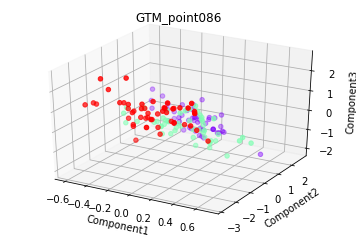

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.328829097580588 tr(Sw)= 74.70414212200605 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 183.7017813124238 tr(Sw)= 86.91033705322609 tr(Sb)/tr(Sw)= 2.1136931179995333
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171435
Explaination 112.53485342528937


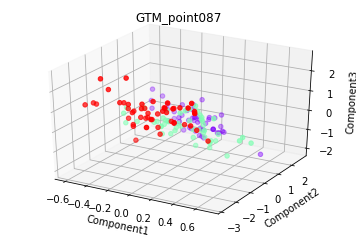

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.36197938918298 tr(Sw)= 74.943904448583 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 182.80200572093628 tr(Sw)= 86.48464820377808 tr(Sb)/tr(Sw)= 2.1136931179995315
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171426
Explaination 112.53485342528974


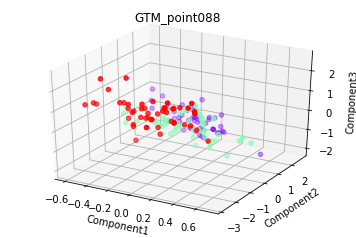

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.311226173469574 tr(Sw)= 74.57682746396229 tr(Sb)/tr(Sw)= 0.13826313781519148
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 188.8404615141277 tr(Sw)= 89.34147530974268 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017133
Explaination 112.5348534252893


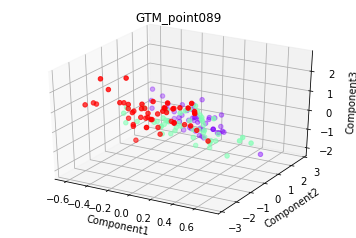

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.651834489973263 tr(Sw)= 77.04030631946854 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 185.2747036512479 tr(Sw)= 87.6544953822807 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528909


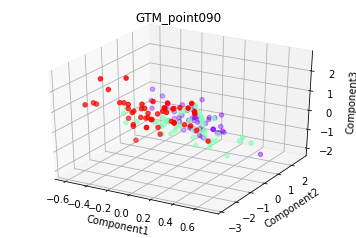

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.450702474714607 tr(Sw)= 75.58560177249447 tr(Sb)/tr(Sw)= 0.13826313781519178
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 182.76791392666806 tr(Sw)= 86.46851918581572 tr(Sb)/tr(Sw)= 2.113693117999519
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171186
Explaination 112.53485342528944


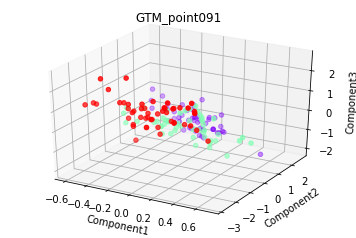

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.309303173774058 tr(Sw)= 74.56291920377146 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 187.1435869113266 tr(Sw)= 88.53867447344774 tr(Sb)/tr(Sw)= 2.1136931179995235
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342529004


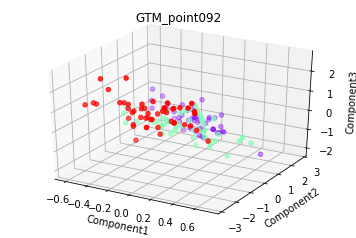

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.556119687783328 tr(Sw)= 76.34804080530188 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 186.03090996930152 tr(Sw)= 88.01226080793019 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017133
Explaination 112.5348534252896


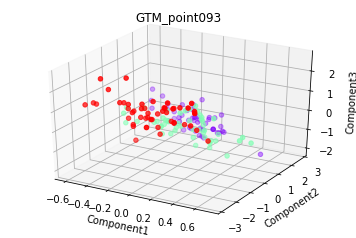

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.493357446406513 tr(Sw)= 75.89410751282367 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 182.24539094083457 tr(Sw)= 86.22131064764889 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528933


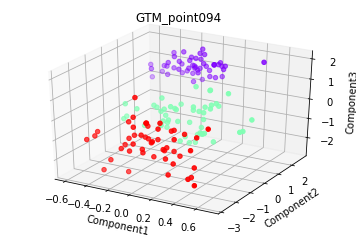

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.279829467145282 tr(Sw)= 74.34974809327514 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 186.1230278775698 tr(Sw)= 88.0558423039777 tr(Sb)/tr(Sw)= 2.113693117999533
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017144
Explaination 112.53485342528921


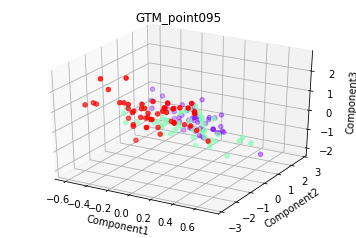

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.498553497637069 tr(Sw)= 75.93168839889839 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037925
Original data
Cluster performance indices: tr(Sb)= 188.825761413788 tr(Sw)= 89.33452061030478 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528934


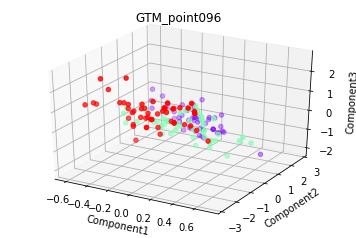

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.651005308374419 tr(Sw)= 77.03430919245454 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 188.8263116742061 tr(Sw)= 89.33478094157668 tr(Sb)/tr(Sw)= 2.113693117999529
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171364
Explaination 112.53485342528944


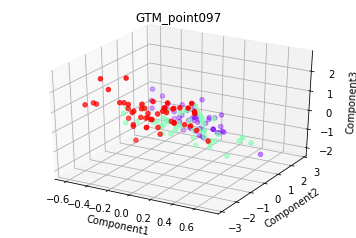

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.651036346653239 tr(Sw)= 77.0345336794675 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 188.3370725497316 tr(Sw)= 89.10331918380864 tr(Sb)/tr(Sw)= 2.1136931179995275
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171337
Explaination 112.53485342528968


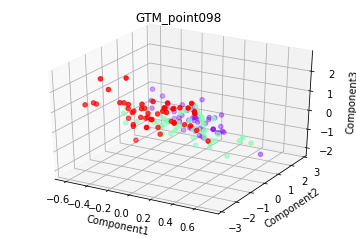

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.62344006703107 tr(Sw)= 76.83494122078157 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 182.87807935091237 tr(Sw)= 86.5206390623039 tr(Sb)/tr(Sw)= 2.113693117999522
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017125
Explaination 112.53485342528981


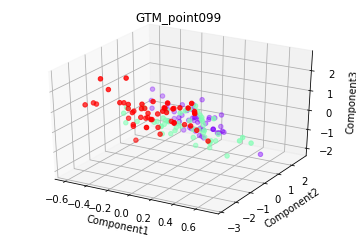

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.315517222692133 tr(Sw)= 74.60786284541214 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 187.4909761240875 tr(Sw)= 88.703026247034 tr(Sb)/tr(Sw)= 2.1136931179995306
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017139
Explaination 112.5348534252897


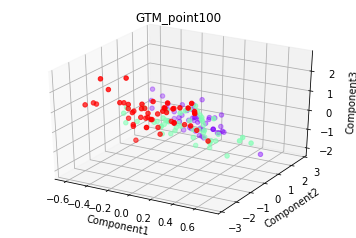

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.575714706606401 tr(Sw)= 76.48976345916839 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 178.09334935975122 tr(Sw)= 84.25695662400845 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528901


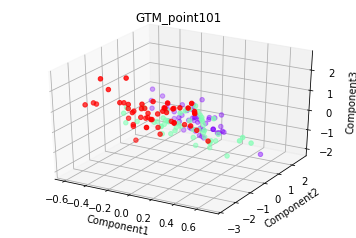

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045627223820038 tr(Sw)= 72.65586028611216 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037924
Original data
Cluster performance indices: tr(Sb)= 184.8573659945326 tr(Sw)= 87.45705060982938 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.5348534252896


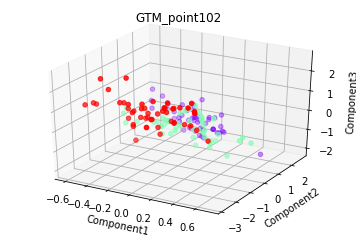

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.42716190713642 tr(Sw)= 75.41534259893486 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.02019109932232 tr(Sw)= 87.0609784988492 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528914


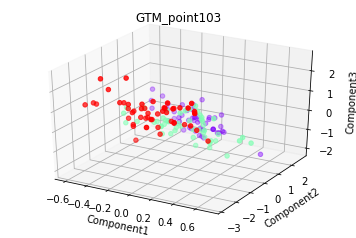

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.379939779254283 tr(Sw)= 75.07380450983663 tr(Sb)/tr(Sw)= 0.13826313781519142
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 186.0133970825299 tr(Sw)= 88.0039753635474 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.53485342528946


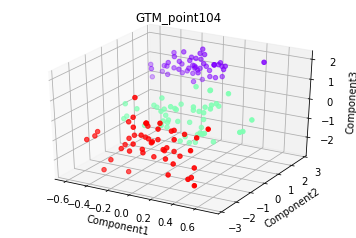

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.49236960529537 tr(Sw)= 75.88696286728222 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 184.394742792941 tr(Sw)= 87.23818099358652 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017132
Explaination 112.53485342528978


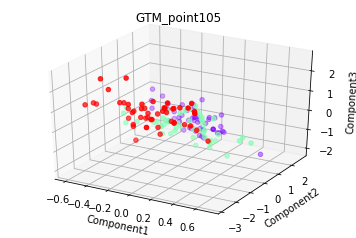

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.401066939272702 tr(Sw)= 75.22660850627601 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 181.9499421830857 tr(Sw)= 86.0815321929465 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528936


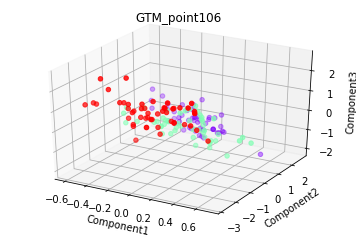

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.263164228972396 tr(Sw)= 74.2292153291832 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 184.1360316551963 tr(Sw)= 87.11578331175585 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528951


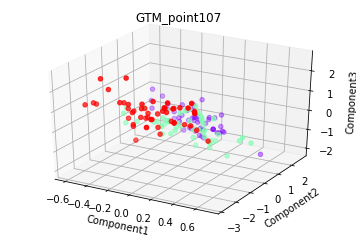

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.386473942634856 tr(Sw)= 75.12106340677626 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703791
Original data
Cluster performance indices: tr(Sb)= 183.52681869220143 tr(Sw)= 86.82756126201423 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528946


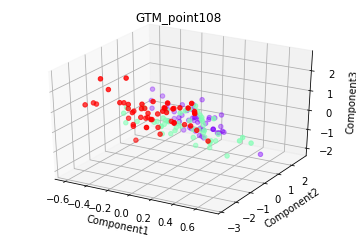

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.35211035551516 tr(Sw)= 74.87252581633311 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 182.73937942607574 tr(Sw)= 86.45501935447794 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.5348534252891


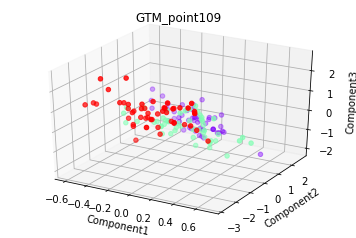

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.307693641711227 tr(Sw)= 74.55127812511333 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 178.09322217911185 tr(Sw)= 84.25689645413871 tr(Sb)/tr(Sw)= 2.1136931179995284
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171306
Explaination 112.53485342528927


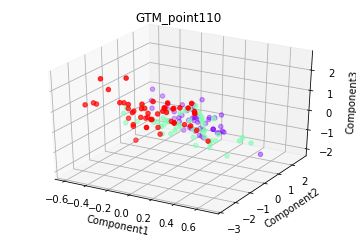

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045620050001904 tr(Sw)= 72.6558084008574 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 182.8793755644474 tr(Sw)= 86.52125230815456 tr(Sb)/tr(Sw)= 2.113693117999532
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171377
Explaination 112.53485342528907


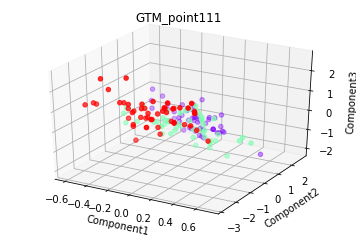

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.315590337595182 tr(Sw)= 74.60839165521791 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 182.73937942607162 tr(Sw)= 86.45501935447598 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528971


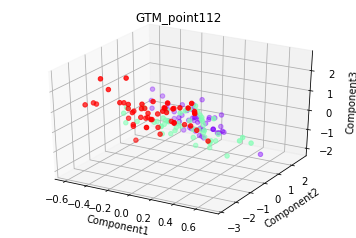

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.30769364171097 tr(Sw)= 74.55127812511145 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 184.38557034258835 tr(Sw)= 87.23384145617938 tr(Sb)/tr(Sw)= 2.113693117999529
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171333
Explaination 112.53485342528961


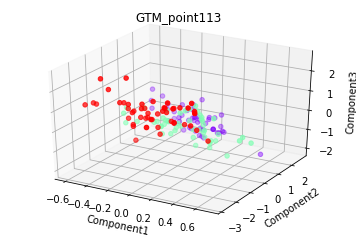

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.400549553209123 tr(Sw)= 75.22286646720656 tr(Sb)/tr(Sw)= 0.13826313781519142
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 179.39597201689404 tr(Sw)= 84.87323466647845 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017125
Explaination 112.53485342528943


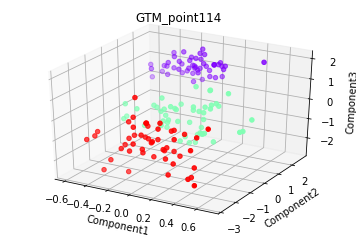

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.11910364320348 tr(Sw)= 73.18728478973978 tr(Sb)/tr(Sw)= 0.13826313781519178
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 183.29652265283048 tr(Sw)= 86.71860692166551 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171346
Explaination 112.53485342528919


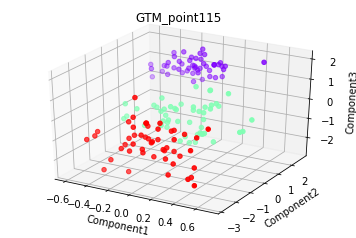

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.33912015587569 tr(Sw)= 74.77857308356042 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 185.66263111151062 tr(Sw)= 87.83802602680018 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528967


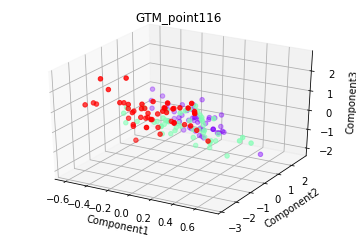

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.472584115268218 tr(Sw)= 75.74386261409973 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 185.69135937107018 tr(Sw)= 87.85161752658544 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528963


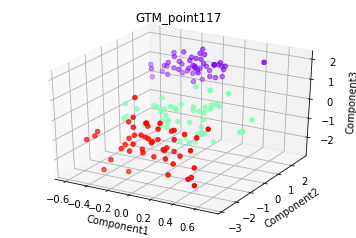

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.47420457660133 tr(Sw)= 75.75558273964239 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 178.09322217911185 tr(Sw)= 84.25689645413873 tr(Sb)/tr(Sw)= 2.113693117999528
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601713
Explaination 112.53485342528931


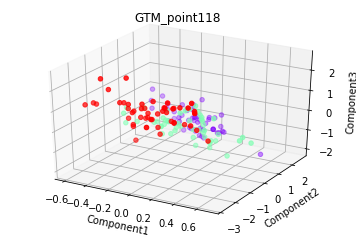

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045620050001911 tr(Sw)= 72.6558084008574 tr(Sb)/tr(Sw)= 0.13826313781519173
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 183.67732035501453 tr(Sw)= 86.89876443788285 tr(Sb)/tr(Sw)= 2.1136931179995213
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528994


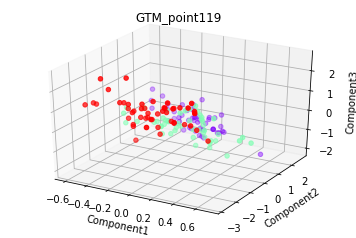

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.3605996315416 tr(Sw)= 74.93392523313045 tr(Sb)/tr(Sw)= 0.13826313781519187
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 179.3959720135799 tr(Sw)= 84.87323466491034 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171306
Explaination 112.53485342528938


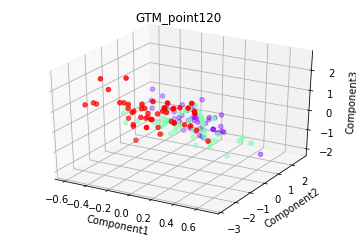

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.1191036430165 tr(Sw)= 73.18728478838753 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 181.1233044952885 tr(Sw)= 85.6904452935486 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.5348534252895


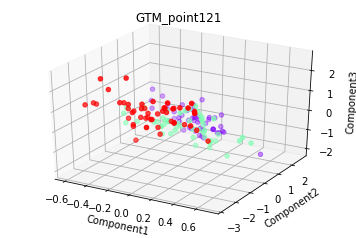

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.21653646835908 tr(Sw)= 73.89197605232229 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 187.1424216506166 tr(Sw)= 88.53812318210838 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017123
Explaination 112.53485342528934


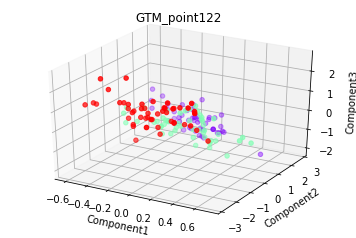

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.556053959474282 tr(Sw)= 76.3475654196707 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 184.01100164785984 tr(Sw)= 87.05663091812238 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528947


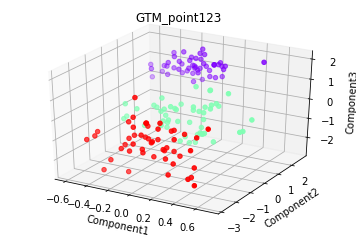

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.379421434217186 tr(Sw)= 75.07005553490878 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 183.55631564864495 tr(Sw)= 86.84151643658154 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171253
Explaination 112.53485342528933


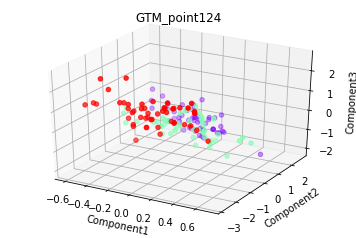

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.353774176369424 tr(Sw)= 74.88455954333044 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037928
Original data
Cluster performance indices: tr(Sb)= 180.56386182068726 tr(Sw)= 85.4257698447631 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171293
Explaination 112.53485342528953


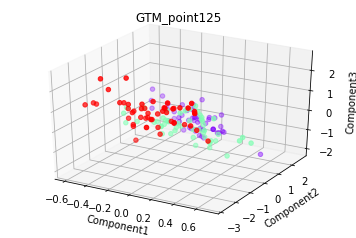

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.184980250328778 tr(Sw)= 73.66374299954376 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921
Original data
Cluster performance indices: tr(Sb)= 182.04970036109714 tr(Sw)= 86.1287283432116 tr(Sb)/tr(Sw)= 2.1136931179995266
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171346
Explaination 112.5348534252894


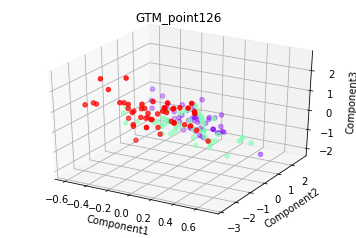

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.26879124128044 tr(Sw)= 74.2699131782048 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 186.62930466710964 tr(Sw)= 88.29536467608985 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171346
Explaination 112.53485342528937


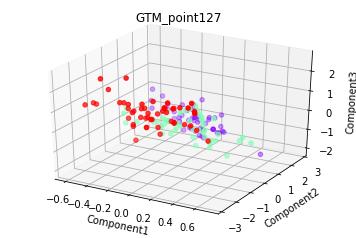

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.527110812764672 tr(Sw)= 76.13823162928401 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 185.59538833542132 tr(Sw)= 87.80621309448898 tr(Sb)/tr(Sw)= 2.113693117999527
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.5348534252896


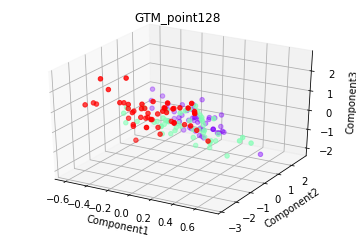

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.46879118383918 tr(Sw)= 75.71642991230395 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 183.7409900872401 tr(Sw)= 86.92888694321873 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017124
Explaination 112.5348534252896


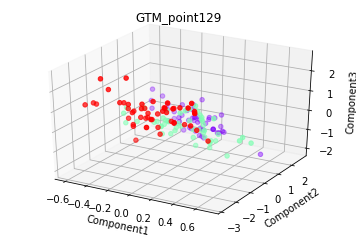

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.364191019977351 tr(Sw)= 74.95990025794563 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 182.86065687525547 tr(Sw)= 86.51239639192345 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528953


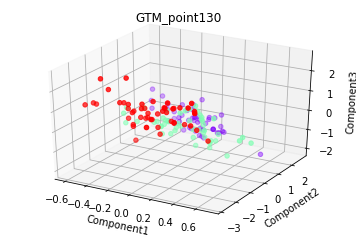

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.314534481357923 tr(Sw)= 74.60075508444459 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 183.5268493493691 tr(Sw)= 86.82757576609114 tr(Sb)/tr(Sw)= 2.113693117999524
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171266
Explaination 112.53485342528947


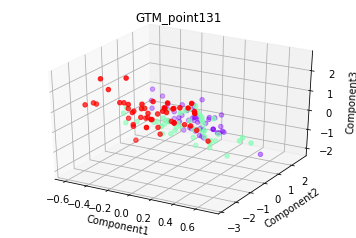

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.352112084779488 tr(Sw)= 74.8725383233857 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 178.09322217911185 tr(Sw)= 84.25689645413871 tr(Sb)/tr(Sw)= 2.1136931179995284
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171306
Explaination 112.53485342528927


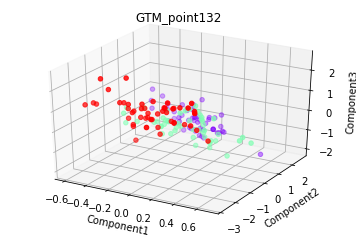

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.045620050001904 tr(Sw)= 72.6558084008574 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037923
Original data
Cluster performance indices: tr(Sb)= 183.74099011313885 tr(Sw)= 86.9288869554716 tr(Sb)/tr(Sw)= 2.1136931179995235
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.53485342528987


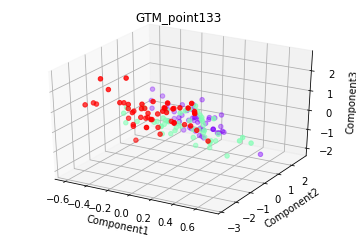

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.364191021438202 tr(Sw)= 74.95990026851126 tr(Sb)/tr(Sw)= 0.13826313781519176
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 184.12131285276473 tr(Sw)= 87.10881976425402 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017128
Explaination 112.53485342528954


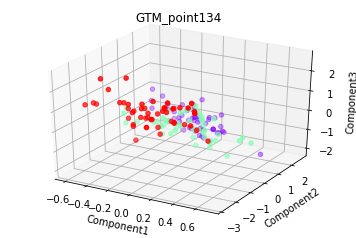

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.385643706115989 tr(Sw)= 75.11505864996262 tr(Sb)/tr(Sw)= 0.1382631378151917
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 183.5563156503747 tr(Sw)= 86.84151643739987 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528955


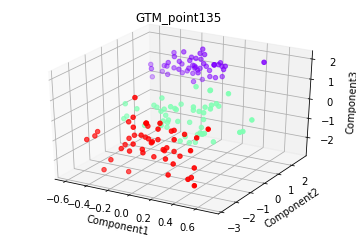

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.353774176466976 tr(Sw)= 74.88455954403602 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037912
Original data
Cluster performance indices: tr(Sb)= 180.2411652429082 tr(Sw)= 85.27310029447173 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017131
Explaination 112.53485342528957


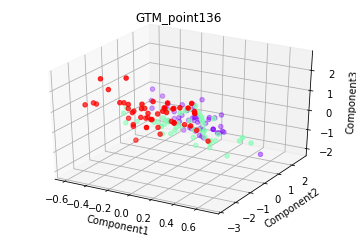

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.16677805727426 tr(Sw)= 73.5320940774801 tr(Sb)/tr(Sw)= 0.13826313781519156
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 181.76980619241363 tr(Sw)= 85.99630885132801 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528938


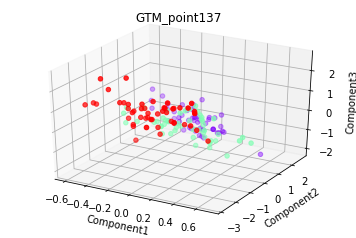

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.253003383447343 tr(Sw)= 74.15572614265375 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037914
Original data
Cluster performance indices: tr(Sb)= 186.21473140503534 tr(Sw)= 88.09922775415725 tr(Sb)/tr(Sw)= 2.1136931179995297
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017134
Explaination 112.5348534252894


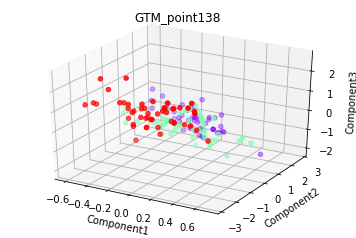

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.50372617508597 tr(Sw)= 75.96910023209297 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 186.34098356859562 tr(Sw)= 88.158958356715 tr(Sb)/tr(Sw)= 2.1136931179995297
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171364
Explaination 112.53485342528987


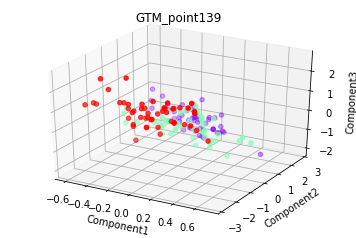

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.510847621091019 tr(Sw)= 76.02060670097237 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037913
Original data
Cluster performance indices: tr(Sb)= 182.8441522068541 tr(Sw)= 86.50458794127327 tr(Sb)/tr(Sw)= 2.1136931179995258
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017133
Explaination 112.5348534252897


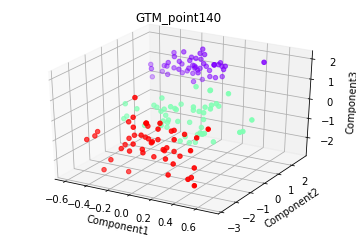

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.313603510342915 tr(Sw)= 74.59402175674997 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037915
Original data
Cluster performance indices: tr(Sb)= 184.26244810993686 tr(Sw)= 87.17559164138711 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171257
Explaination 112.53485342528933


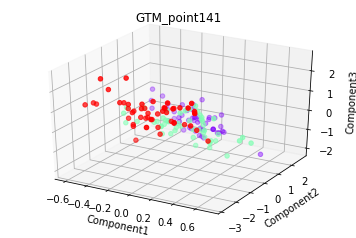

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.393604655734741 tr(Sw)= 75.17263690071377 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 182.63745251212987 tr(Sw)= 86.40679716314926 tr(Sb)/tr(Sw)= 2.1136931179995293
Invariant criterion:         tr(inv(Sw)*Sb)= 3.53498990601714
Explaination 112.53485342528975


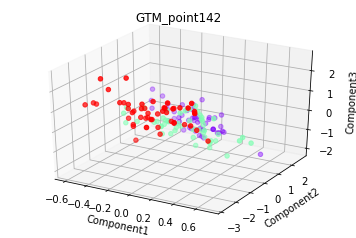

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.301944298542228 tr(Sw)= 74.50969550765043 tr(Sb)/tr(Sw)= 0.1382631378151915
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 184.8573659945326 tr(Sw)= 87.45705060982938 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171275
Explaination 112.5348534252896


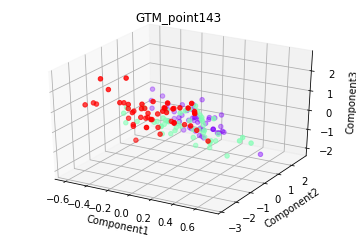

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.42716190713642 tr(Sw)= 75.41534259893486 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037916
Original data
Cluster performance indices: tr(Sb)= 180.2456751058581 tr(Sw)= 85.27523393578016 tr(Sb)/tr(Sw)= 2.1136931179995253
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528955


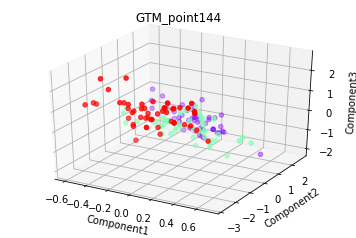

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.167032442978106 tr(Sw)= 73.5339339438961 tr(Sb)/tr(Sw)= 0.13826313781519164
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 181.1606695215793 tr(Sw)= 85.70812289583283 tr(Sb)/tr(Sw)= 2.1136931179995244
Invariant criterion:         tr(inv(Sw)*Sb)= 3.534989906017124
Explaination 112.53485342528938


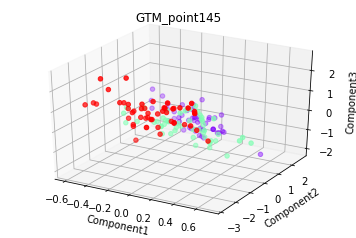

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.2186440997034 tr(Sw)= 73.90721967674475 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 184.26278927856643 tr(Sw)= 87.1757530501679 tr(Sb)/tr(Sw)= 2.11369311799953
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171373
Explaination 112.53485342528927


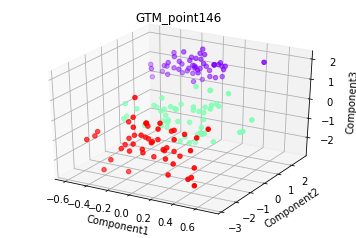

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.393623899872047 tr(Sw)= 75.17277608558697 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037918
Original data
Cluster performance indices: tr(Sb)= 179.39688681464736 tr(Sw)= 84.87366746239636 tr(Sb)/tr(Sw)= 2.113693117999525
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171284
Explaination 112.53485342528963


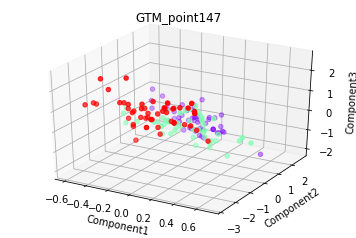

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.119155243767114 tr(Sw)= 73.18765799524103 tr(Sb)/tr(Sw)= 0.13826313781519153
Invariant criterion:         tr(inv(Sw)*Sb)= 0.635509497703792
Original data
Cluster performance indices: tr(Sb)= 185.253099683629 tr(Sw)= 87.64427442473723 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171297
Explaination 112.53485342528941


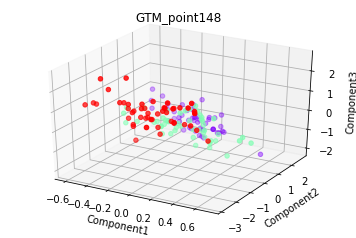

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.449483869943338 tr(Sw)= 75.57678810899375 tr(Sb)/tr(Sw)= 0.13826313781519162
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037917
Original data
Cluster performance indices: tr(Sb)= 182.2412174906438 tr(Sw)= 86.21933616509256 tr(Sb)/tr(Sw)= 2.113693117999526
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171337
Explaination 112.53485342528957


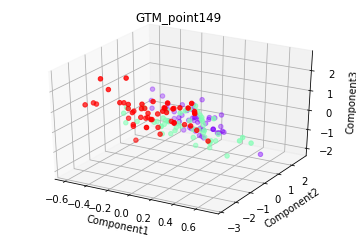

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.279594057316622 tr(Sw)= 74.34804547150353 tr(Sb)/tr(Sw)= 0.1382631378151916
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037912
Original data
Cluster performance indices: tr(Sb)= 187.52625333244293 tr(Sw)= 88.7197160910117 tr(Sb)/tr(Sw)= 2.1136931179995226
Invariant criterion:         tr(inv(Sw)*Sb)= 3.5349899060171235
Explaination 112.53485342528987


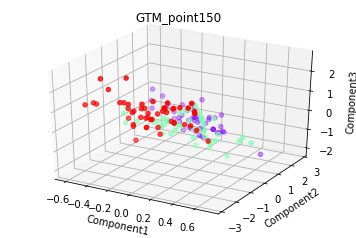

Original data projected onto 3D using the largest 3 eigenvalues of the scatter matrices in the original domain
Cluster performance indices: tr(Sb)= 10.57770457139314 tr(Sw)= 76.50415532686482 tr(Sb)/tr(Sw)= 0.13826313781519167
Invariant criterion:         tr(inv(Sw)*Sb)= 0.6355094977037921


In [8]:
folder = './imgs/iris/v4'
GT(iris.data,iris.target,gtm_flag=True,folder=folder)

#folder = './imgs/iris/v5'
#GT(iris.data,iris.target,gtm_flag=False,folder=folder)
#folder = './imgs/sonar/v4'
#GT(sonar[list(sonar)[:-1]].values,sonar_labels.values,gtm_flag=True,folder=folder)
#folder = './imgs/sonar/v5'
#GT(sonar[list(sonar)[:-1]].values,sonar_labels.values,gtm_flag=False,folder=folder)

In [26]:
folder = './imgs/urban/v4'
GT(urban[list(urban)[1:]].values,urban_labels.values,gtm_flag=True,folder=folder)
#folder = './imgs/urban/v5'
#GT(urban[list(urban)[1:]].values,urban_labels.values,gtm_flag=False,folder=folder)
#folder = './imgs/olive/v4'
#GT(olive[list(olive)[2:]].values,olive_labels.values,gtm_flag=True,folder=folder)
#folder = './imgs/olive/v5'
#GT(olive[list(olive)[2:]].values,olive_labels.values,gtm_flag=False,folder=folder)
#list(olive.dtypes)

beta
1.0469501651900721
cycle #1: likelihood: -125532.878, diff: inf
beta
2.0771475171355


C:\Users\Alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


cycle #2: likelihood: nan, diff: nan
beta
nan
cycle #3: likelihood: nan, diff: nan
beta
nan
cycle #4: likelihood: nan, diff: nan
beta
nan
cycle #5: likelihood: nan, diff: nan
beta
nan
cycle #6: likelihood: nan, diff: nan
beta
nan
cycle #7: likelihood: nan, diff: nan
beta
nan
cycle #8: likelihood: nan, diff: nan
beta
nan
cycle #9: likelihood: nan, diff: nan
beta
nan
cycle #10: likelihood: nan, diff: nan
beta
nan
cycle #11: likelihood: nan, diff: nan
beta
nan
cycle #12: likelihood: nan, diff: nan
beta
nan
cycle #13: likelihood: nan, diff: nan
beta
nan
cycle #14: likelihood: nan, diff: nan
beta
nan
cycle #15: likelihood: nan, diff: nan
beta
nan
cycle #16: likelihood: nan, diff: nan
beta
nan
cycle #17: likelihood: nan, diff: nan
beta
nan
cycle #18: likelihood: nan, diff: nan
beta
nan
cycle #19: likelihood: nan, diff: nan
beta
nan
cycle #20: likelihood: nan, diff: nan
beta
nan
cycle #21: likelihood: nan, diff: nan
beta
nan
cycle #22: likelihood: nan, diff: nan
beta
nan
cycle #23: likelihood

LinAlgError: SVD did not converge